<div align="center">

![hou](https://datahack-prod.s3.ap-south-1.amazonaws.com/__sized__/contest_cover/is_this_funny-thumbnail-1200x1200-70.jpg)

</div>

Nesta competição da Analytics Vidhya temos que prever notas que são atribuidas a piadas, poderiamos abordar esse problema de outra pespectiva, mas temos aqui um problema de recomendação (**RecSys**). Para validarmos o modelo vou utilizar a métrica **RMSE** estipulada pela competição.

<p align="center">
    <img width="700" height="250" src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*kgBD8OuP7SMsL63gcsQ90Q.png">
</p>

Os exemplos são diversos: a Amazon recomenda livros (ou qual coisa do marketplace), a Netflix faz recomendação de Filmes, o Mendeley recomenda artigos ciêntíficos, a Globo.com recomenda notícias e o Spotify as músicas.

*   Temos algumas opções de algoritimos de Machine Learning para RecSys.

    *   Filtragem Baseada em Conteúdo (Content-Based)
    *   Filtragem Colaborativa (Collaborative Filter)
    *   Sistemas Híbridos (Hybrid)
    *   Cold-Start

Aqui não abordarei as vantagens e desvatagens deles, na seção Modelo onde criaremos nossa máquina preditiva, abordarei um pouco sobre a escolha realizada.

In [137]:
# Importando bibliotecas.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt.callbacks import EarlyStopper

from scipy import stats
from statistics import stdev, mean

from surprise import Reader, Dataset, accuracy, SVD
from surprise.model_selection import KFold, train_test_split, cross_validate
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")
#pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)

# Análise Exploratória
Aqui iremos realizar uma breve exploração de nossos dados, demostrar algumas estáticas. Nosso dataset já é conhecido, temos apenas quatro features e nossa variável alvo é a Rating(nota) atribuida pelos usuários às piadas.

* **Arquivos**

    *   train.csv - arquivo destinano para treino e teste.
    *   test.csv - arquivo que será usado para criar o submission.csv, e enviaremos as previsões do modelo.

In [56]:
# Importando dados
dados = pd.read_csv("dados/train.csv")
valid = pd. read_csv("dados/test.csv")
jokes = pd.read_csv("dados/jokes.csv")

In [45]:
# Dataset de treino.
dados.head()

,id,user_id,joke_id,Rating
0,31030_110,31030,110,2.750
1,16144_109,16144,109,5.094
2,23098_6,23098,6,-6.438
3,14273_86,14273,86,4.406
4,18419_134,18419,134,9.375


In [46]:
# Dataset de teste.
valid.head()

,id,user_id,joke_id
0,6194_11,6194,11
1,19356_3,19356,3
2,23426_79,23426,79
3,40030_3,40030,3
4,19806_115,19806,115


In [47]:
dados.shape, valid.shape

((1092059, 4), (537880, 3))

In [48]:
# Verificando algumas informações do nosso dataset.
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092059 entries, 0 to 1092058
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   id       1092059 non-null  object 
 1   user_id  1092059 non-null  int64  
 2   joke_id  1092059 non-null  int64  
 3   Rating   1092059 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 33.3+ MB


Podemos verificar que nossa variável alvo(target), já assume um valor do tipo numérico, e não encontramos valores ausentes em nosso dataset.

In [ ]:
dados.joke_id.value_counts()

In [ ]:
#train["joke_text"] = train.joke_id.apply(lambda x: jokes.loc[jokes.joke_id == x, "joke_text"][x-1])
#test["joke_text"] = test.joke_id.apply(lambda x: jokes.loc[jokes.joke_id == x, "joke_text"][x-1])
# Cheching uniqueness of data
#train.select_dtypes(["int64", "float64", "object"]).nunique().sort_values().to_frame().T

## Estátisticas
Aqui vamos verificar algumas medidas de posisão e dispersão....

In [80]:
# Média, desvio padrão amostral e variança amostral da feature Rating
print("Média Rating:", mean(dados.Rating))
print("Desvio Padrão Rating:", stdev(dados.Rating))
print("Valor Min. Rating:", min(dados.Rating))
print("Valor Max. Rating:", max(dados.Rating))

Média Rating: 1.7583939732193956
Desvio Padrão Rating: 5.2308597557955006
Valor Min. Rating: -10.0
Valor Max. Rating: 10.0


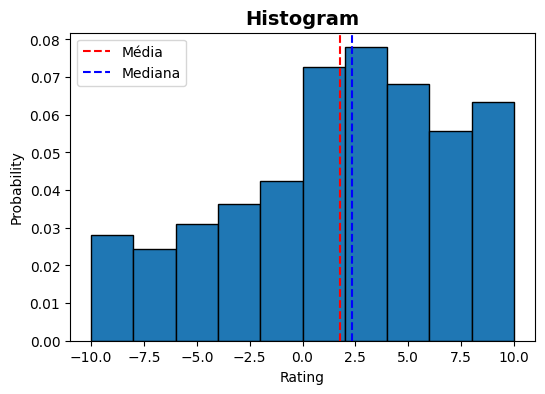

In [83]:
# Histograma da nossa variável alvo Rating.
plt.figure(figsize=(6, 4))
plt.hist(dados.Rating, density=True, edgecolor="black")
plt.title("Histogram", fontweight="bold", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Probability")
plt.axvline(dados.Rating.mean(), color="red", linestyle="--")
plt.axvline(dados.Rating.median(), color="blue", linestyle="--")
plt.legend(title="", labels=["Média","Mediana"], ncol=1, loc="best")
#plt.spines['right'].set_visible(False)
#plt.spines['top'].set_visible(False)
plt.show()

In [51]:
# Realisando teste de Shapiro-Wilk, onde verificamos se às variáveis segue uma distribuição normal.
print(stats.shapiro(dados.Rating))

ShapiroResult(statistic=0.9625284671783447, pvalue=0.0)


Com nosso histograma e o teste de Shapiro Wilk podemos verificar que nosso alvo não segue uma distribuição normal. Para os testes realizados temos um p-value menor que 0.05, com intervalo de confiança de 95% e meu alfa de 5%, devo rejeita minha hipótese nula (H0) de que a variável Rating seguem uma distribuição normal e aceita a hipótese alternativa (Ha) de que meus dados não tem uma distribuição normal.

# Tratamento dos Dados
Nesta seção realizamos procedimentos como feature scaling, feature engineer, select feature entre outros, tudo isso a fim de encontrarmos um padão nos dados. Iremos utilizar alguns desses recursos de acordo com o desenvolvimento e resultados que vamos obtendo.

## Split dos Dados
Neste caso vou dar preferência por utilizar Hod-Out, para realizar o split em uma proporção de 80% para treino e 20% para teste.

In [106]:
#
reader = Reader(rating_scale=(-10., 10.))

#
data = Dataset.load_from_df(dados[["user_id", "joke_id", "Rating"]], reader)

# Realizando split dos dados entre treino e teste.
X_train, X_test = train_test_split(data, test_size=0.2)
#4, 10,

# Modelos

Utilizando à biblioteca [_**Surprise**_](https://surpriselib.com/), irei cria alguns modelos utilizando **SVD** _(Singular Value Decomposition)_, _Filtragem Colaborativa_.

A Filtragem Colaborativa ignora as características do conteúdo e foca na interação entre o Usuário X Conteúdo. Parte do princípio que o sistema não precisa saber as características do conteúdo, mas sim quais conteúdos o usuário consumiu para identificar quais outros usuários tiveram o mesmo comportamento de consumo. Dessa forma é possível “trocar” recomendações entre usuários semelhantes ao processar o coletivo.

<div align="center">

![hou](https://miro.medium.com/v2/resize:fit:638/format:webp/0*e3_p3-HIh8DCin4m)

</div>

O **SVD** realiza a fatoração de matrizes, isso pode ser um problema quando temos muitos dados, pois às matrizes seram muito esparsas, isso resultarar em custo computacional muito alto levando muito tempo de processamento. Mas vamos em frente....

$$
\begin{align} 
\hat r_i = \mu + b_u + b_i + q_i^T p_u
\end{align}
$$

## Modelo inicial

Crindo modelo utilizando parâmetros default, vamos obter nossa RMSE e trabalhar para melhorar nossa métrica.

In [119]:
# Trabalhando com aleatoriedade, criar um modelo e treina-lo por n vezes onde vamos 
# trocar a rando_state, usando numeros pares até sed 60, e ober a melhor sed.
mrmse = []

for rand_sed in range(2,61,2):
    # Criando modelo.
    model_svd = SVD(random_state=rand_sed)
    # Treinando o modelo.
    model_svd.fit(X_train)
    # Realizando previsões.
    predic = model_svd.test(X_test)
    result = round(accuracy.rmse(predic, verbose=False),10)
    mrmse.append((result, rand_sed))

print('Melhor resultado:', min(mrmse))

Melhor resultado: (4.2779995965, 10)


Primeira tentativa já utilizando alguma técnica, nesse caso trabalhei à aleatoriedade e já obtivemos um bom resultado, uma RMSE de 4.2779 com uma sed 10. 

# Tuning do Modelo
Bayesian optimization

In [128]:
# Parâmetros usados pela nossa função de otimização, que serão passados para o modelo.
space = [
    Integer(500, 650, name="n_factors"),
    Integer(100, 250, name="n_epochs"),
    Real(1e-3, 1e-1, "log-uniform", name="lr_bu"),
    Real(1e-3, 1e-1, "log-uniform", name="lr_bi"),
    Real(1e-3, 1e-1, "log-uniform", name="lr_pu"),
    Real(1e-3, 1e-1, "log-uniform", name="lr_qi"),
    Real(1e-3, 1e-1, "log-uniform", name="reg_bu"),
    Real(1e-3, 1e-1, "log-uniform", name="reg_bi"),
    Real(1e-3, 1e-1, "log-uniform", name="reg_pu"),
    Real(1e-3, 1e-1, "log-uniform", name="reg_qi")
]

@use_named_args(space)
def svd_bayesian(**params):
    """ 
    Função para criação do modelo que recebe os parâmetros (lr_bu, lr_bi, lr_pu, lr_qi, reg_bu, reg_bi, reg_pu e reg_qi), 
    por meio da função de otimização.
    """
    model_svd = SVD(**params, verbose=False, random_state=10)
    model_svd.fit(X_train)
    predic = model_svd.test(X_test)
    result = round(accuracy.rmse(predic), 10)

    return result

In [ ]:
# Função de Otimização.
res_gp = gp_minimize(
    func=svd_bayesian, 
    dimensions=space,
    n_initial_points=5, 
    n_calls=25,
    verbose=False, 
    random_state=10
)

print('\n')
print('Best RMSE: %.10f' % (res_gp.fun)) 
print('Best Parameters: %s' % (res_gp.x))

In [147]:
for rand_sed in range(2,41,2):
    #
    model_svd = SVD(
        n_factors=628,
        n_epochs=203,
        lr_bu=0.009388724398649437, 
        lr_bi=0.014980478328026079, 
        lr_pu=0.026445841298735544, 
        lr_qi=0.00306434987836987, 
        reg_bu=0.010422331957134049, 
        reg_bi=0.007467369368383485,
        reg_pu=0.0023025456770393864,
        reg_qi=0.08327985544490146,
        random_state=rand_sed
    )
    model_svd.fit(X_train)
    predic = model_svd.test(X_test)
    result = round(accuracy.rmse(predic, verbose=False),10)
    mrmse.append((result, rand_sed))

print('Melhor resultado:', min(mrmse))

## Cross-validation

In [66]:
mrmse = []
kfold = 0
kf = KFold(n_splits=5, random_state=6)

for trainset, testset in kf.split(data):
    model_svd.fit(trainset)
    predic = model_svd.test(testset)
    result = round(accuracy.rmse(predic, verbose=False), 10)
    mrmse.append(result)
    kfold += 1
    print("Fold:", kfold, "RMSE:", result)
    #if round(mean(mrmse), 10) < 3.9912059635:
        #break
    
print("Média RMSE CV", mean(mrmse))

Fold: 1 RMSE: 4.0416530409
Fold: 2 RMSE: 4.0420271459
Fold: 3 RMSE: 4.0440182247
Fold: 4 RMSE: 4.0420395807
Fold: 5 RMSE: 4.0419704534
Média RMSE CV 4.04234168912


In [14]:
kf = KFold(n_splits=25, random_state=4)
mrmse = []

@use_named_args(space)
def svd_bayesian_cv(**params):
    """ """
    kfold = 0
    mrmse.clear()
    model_svd = SVD(**params, verbose=False, random_state=4)

    for trainset, testset in kf.split(data):
        model_svd.fit(trainset)
        predic = model_svd.test(testset)
        result = round(accuracy.rmse(predic, verbose=False), 10)
        mrmse.append(result)
        kfold += 1
        print("Fold:", kfold, "RMSE:", result)
    
    print("Média RMSE CV", mean(mrmse), "\n")
    return min(mrmse)

In [ ]:
# Gaussian processes
res_gp_cv = gp_minimize(
    func=svd_bayesian_cv, 
    dimensions=space,
    n_initial_points=5, 
    n_calls=15,
    verbose=False, 
    random_state=4
)

print('Best RMSE: %.10f' % (res_gp_cv.fun)) 
print('Best Parameters: %s' % (res_gp_cv.x))

Best RMSE: 3.9803072135
Best Parameters: [628, 203, 0.009388724398649437, 0.014980478328026079, 0.026445841298735544, 0.00306434987836987, 0.010422331957134049, 0.007467369368383485, 0.0023025456770393864, 0.08327985544490146]

Best RMSE: 4.0045086550
Best Parameters: [625, 204, 0.009521989486717746, 0.01336601625705214, 0.026640477454712163, 0.003017502613450248, 0.010572948868702966, 0.00730756395607531, 0.0023854022807244723, 0.0841150726472552]

Best RMSE: 4.0070194611
Best Parameters: [543, 117, 0.002309160264028181, 0.009740461529916337, 0.013537244049515073, 0.0027776040326523213, 0.0342753850084279]

In [ ]:
plot_convergence(res_gp)
plt.show()

## Submission

In [28]:
pred = []

for i in trange(test.shape[0]):
    pred.append((test.iloc[i, 0], model_svd.predict(test.iloc[i, 1], test.iloc[i, 2])[3]))

100%|██████████| 537880/537880 [01:25<00:00, 6262.20it/s]


In [29]:
# Gerando CSV submission
sub = pd.DataFrame(pred, columns=["id", "Rating"])
sub.to_csv("submission.csv", index=False)